## 이상치 처리 전 데이터 요약

In [64]:
import pandas as pd

df = pd.read_csv('../data/dataset/코스피_전처리완.csv')
feature = df[df.columns[6:]]

C:\Users\Master\AppData\Local\Temp\ipykernel_19964\2862330069.py:17: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()  # subplot 간격 조정
c:\Users\Master\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


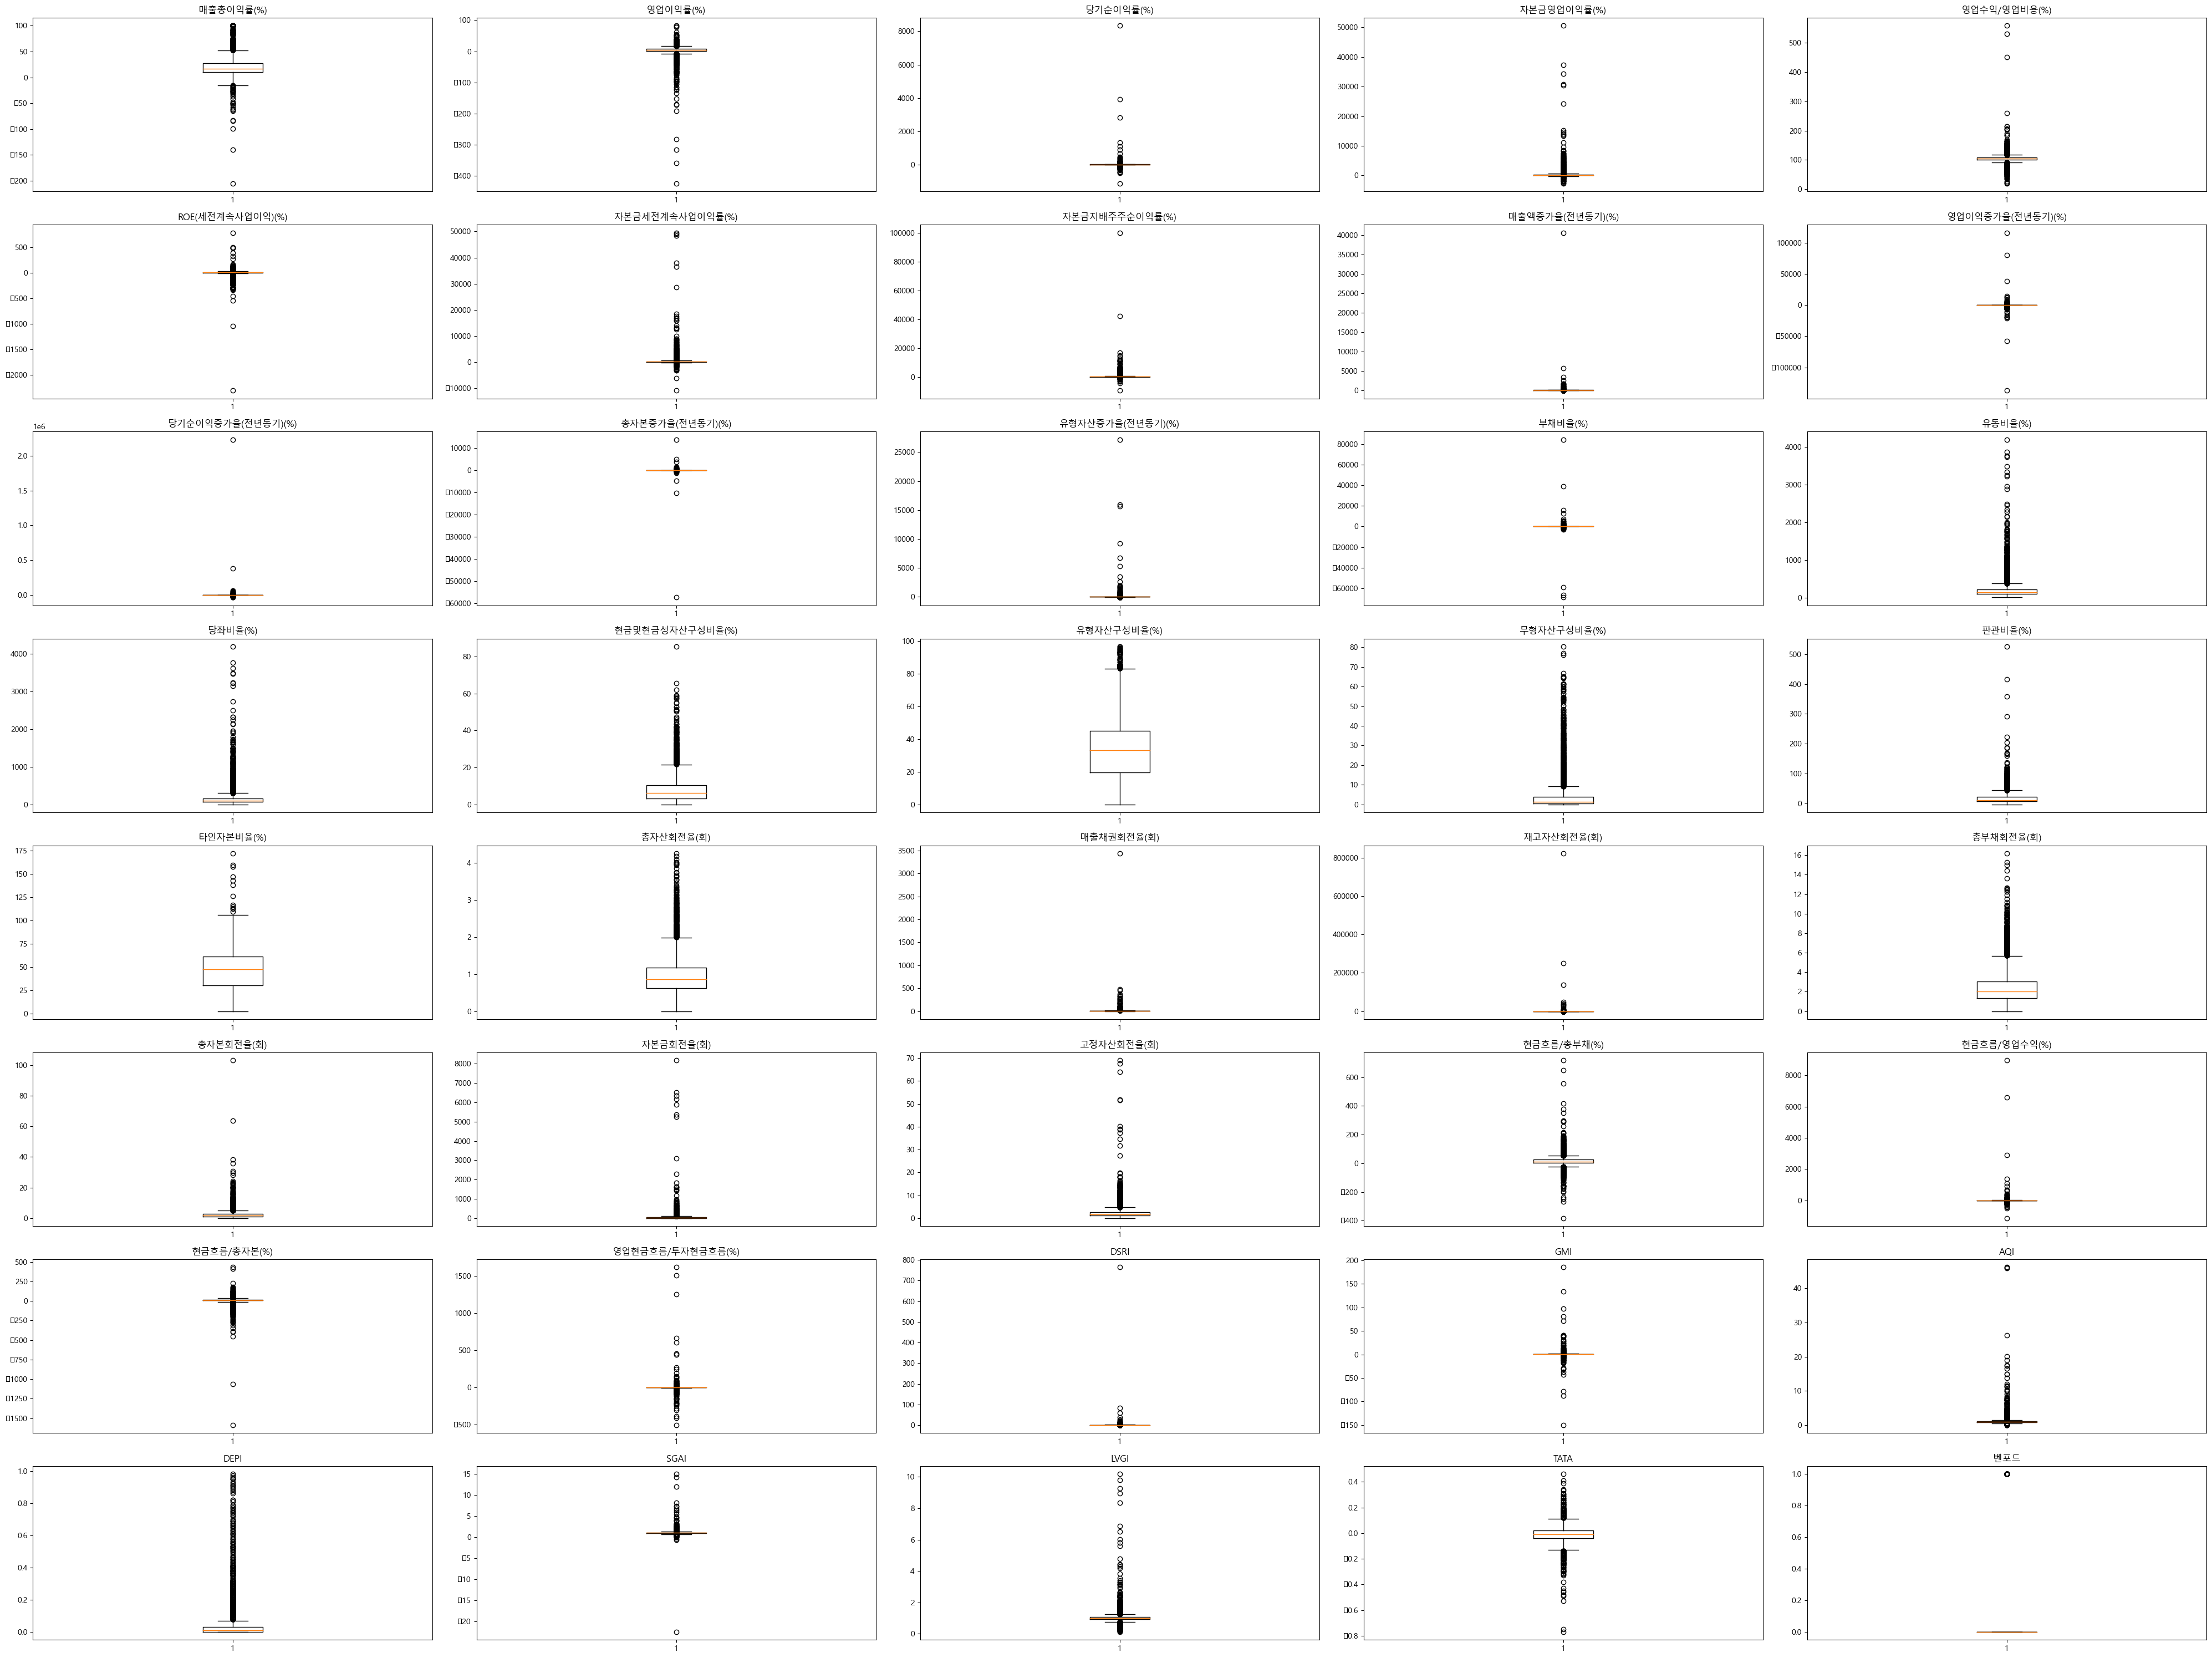

In [65]:
from matplotlib import font_manager, rc
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'

selected_variables = feature
# 5x4 subplot 생성
fig, axes = plt.subplots(8, 5, figsize=(40, 30))
axes = axes.flatten()  # 2D axes 배열을 1D 배열로 변환

for i, var in enumerate(selected_variables):
    # i번째 axes에 i번째 변수의 히스토그램을 그림
    axes[i].boxplot(df[var])
    axes[i].set_title(var)  # 각 히스토그램에 변수 이름을 제목으로 설정

plt.tight_layout()  # subplot 간격 조정
plt.show()

In [66]:
df[df.columns[6:-1]].describe()

,매출총이익률(%),영업이익률(%),당기순이익률(%),자본금영업이익률(%),영업수익/영업비용(%),ROE(세전계속사업이익)(%),자본금세전계속사업이익률(%),자본금지배주주순이익률(%),매출액증가율(전년동기)(%),영업이익증가율(전년동기)(%),...,현금흐름/영업수익(%),현금흐름/총자본(%),영업현금흐름/투자현금흐름(%),DSRI,GMI,AQI,DEPI,SGAI,LVGI,TATA
count,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,...,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000
mean,22.209114,3.405311,4.007078,294.809691,104.988308,3.513471,303.504526,218.220121,17.552743,-15.957138,...,8.853234,8.840080,-0.720186,1.185052,1.048671,1.151205,0.037818,1.035170,1.017021,-0.010810
std,20.894736,14.429133,120.910876,1284.000571,13.750534,44.673243,1540.535422,1502.310294,496.233344,2602.185223,...,142.187665,34.950432,37.128371,9.232627,4.379305,1.290004,0.089672,0.492068,0.349784,0.063234
min,-205.560000,-425.680000,-1148.680000,-2763.250000,19.020000,-2309.940000,-10953.290000,-9530.530000,-99.860000,-137079.350000,...,-1134.880000,-1586.700000,-506.860000,0.000000,-150.020000,0.040000,0.000000,-22.520000,0.110000,-0.770000
25%,10.180000,1.390000,0.220000,15.110000,101.410000,1.080000,6.000000,2.420000,-4.470000,-46.510000,...,2.760000,5.060000,-1.790000,0.870000,0.900000,0.900000,0.000000,0.930000,0.930000,-0.040000
50%,16.360000,4.120000,2.960000,81.460000,104.300000,6.770000,73.680000,51.390000,3.760000,-3.650000,...,6.080000,10.450000,-0.850000,0.980000,1.000000,1.000000,0.010000,1.010000,0.990000,-0.010000
75%,27.210000,7.500000,6.390000,247.480000,108.110000,12.910000,256.230000,181.570000,13.890000,36.230000,...,10.280000,17.010000,-0.060000,1.100000,1.100000,1.130000,0.030000,1.090000,1.050000,0.020000
max,100.000000,82.100000,8332.240000,50556.070000,558.730000,786.250000,49541.570000,100051.640000,40693.190000,116066.340000,...,8962.910000,431.730000,1621.390000,765.130000,185.240000,46.180000,0.980000,14.930000,10.180000,0.460000


## 2. 이상치 처리
컬럼마다 이상치의 분포가 상하위, 상위, 하위에 분포하는 비율이 다르기 때문에 각자 다르게 이상치 조정 필요
- 상하위 고르게 분포한 컬럼
- 상위에 분포한 컬럼
- 하위에 분포한 컬럼

In [67]:
import numpy as np
from scipy.stats import mstats
import statsmodels.api as sm

# 중앙값과 절대 중앙값 편차 (MAD) 계산 함수
def mad_based_outliers(df, threshold=3):        # 임계값은 3으로 설정
    median = np.median(df)
    mad = sm.robust.scale.mad(df)
    mad_scaled = np.abs(df - median) / mad if mad != 0 else 0
    return mad_scaled > threshold

# 윈저라이징 조건 설정 함수
def apply_winsorization_based_on_outliers(df, threshold=3):
    winsorization_info = {}  # 각 컬럼별 윈저라이징 방식을 저장할 딕셔너리

    for column in df.columns:
        # MAD 기반 이상치 탐지
        outliers_mask = mad_based_outliers(df[column], threshold)
        outliers_high = np.sum(outliers_mask & (df[column] > np.median(df[column])))
        outliers_low = np.sum(outliers_mask & (df[column] < np.median(df[column])))

        # 조건에 따라 윈저라이징 방식 결정
        if outliers_high > 0 and outliers_low == 0:  # 상위 이상치만 있을 때
            df[column] = mstats.winsorize(df[column], limits=(0, 0.02))  # 상위 2%만 윈저라이징
            winsorization_info[column] = "상위 2% 윈저라이징"
        elif outliers_low > 0 and outliers_high == 0:  # 하위 이상치만 있을 때
            df[column] = mstats.winsorize(df[column], limits=(0.02, 0))  # 하위 2%만 윈저라이징
            winsorization_info[column] = "하위 2% 윈저라이징"
        elif outliers_high > 0 and outliers_low > 0:  # 상하위 이상치가 모두 있을 때
            df[column] = mstats.winsorize(df[column], limits=(0.01, 0.01))  # 상하위 1%씩 윈저라이징
            winsorization_info[column] = "상하위 1% 윈저라이징"
    return winsorization_info

In [70]:
winsorization_info = apply_winsorization_based_on_outliers(feature)

C:\Users\Master\AppData\Local\Temp\ipykernel_19964\2069085115.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = mstats.winsorize(df[column], limits=(0, 0.02))  # 상위 2%만 윈저라이징
C:\Users\Master\AppData\Local\Temp\ipykernel_19964\2069085115.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = mstats.winsorize(df[column], limits=(0.01, 0.01))  # 상하위 1%씩 윈저라이징


In [71]:
winsorization_info

{'매출총이익률(%)': '상위 2% 윈저라이징',
 '영업이익률(%)': '상하위 1% 윈저라이징',
 '당기순이익률(%)': '상하위 1% 윈저라이징',
 '자본금영업이익률(%)': '상하위 1% 윈저라이징',
 '영업수익/영업비용(%)': '상하위 1% 윈저라이징',
 'ROE(세전계속사업이익)(%)': '상하위 1% 윈저라이징',
 '자본금세전계속사업이익률(%)': '상하위 1% 윈저라이징',
 '자본금지배주주순이익률(%)': '상하위 1% 윈저라이징',
 '매출액증가율(전년동기)(%)': '상하위 1% 윈저라이징',
 '영업이익증가율(전년동기)(%)': '상하위 1% 윈저라이징',
 '당기순이익증가율(전년동기)(%)': '상하위 1% 윈저라이징',
 '총자본증가율(전년동기)(%)': '상하위 1% 윈저라이징',
 '유형자산증가율(전년동기)(%)': '상하위 1% 윈저라이징',
 '부채비율(%)': '상위 2% 윈저라이징',
 '유동비율(%)': '상위 2% 윈저라이징',
 '당좌비율(%)': '상위 2% 윈저라이징',
 '현금및현금성자산구성비율(%)': '상위 2% 윈저라이징',
 '무형자산구성비율(%)': '상위 2% 윈저라이징',
 '판관비율(%)': '상위 2% 윈저라이징',
 '총자산회전율(회)': '상위 2% 윈저라이징',
 '매출채권회전율(회)': '상위 2% 윈저라이징',
 '재고자산회전율(회)': '상위 2% 윈저라이징',
 '총부채회전율(회)': '상위 2% 윈저라이징',
 '총자본회전율(회)': '상위 2% 윈저라이징',
 '자본금회전율(회)': '상위 2% 윈저라이징',
 '고정자산회전율(회)': '상위 2% 윈저라이징',
 '현금흐름/총부채(%)': '상하위 1% 윈저라이징',
 '현금흐름/영업수익(%)': '상하위 1% 윈저라이징',
 '현금흐름/총자본(%)': '상하위 1% 윈저라이징',
 '영업현금흐름/투자현금흐름(%)': '상하위 1% 윈저라이징',
 'DSRI': '상하위 1% 윈저라이징',
 'GMI': '상하위 1% 

In [50]:
feature.describe()

c:\Users\Master\anaconda3\lib\site-packages\numpy\lib\function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\Master\anaconda3\lib\site-packages\numpy\lib\function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\Master\anaconda3\lib\site-packages\numpy\lib\function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\Master\anaconda3\lib\site-packages\numpy\lib\function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\Master\anaconda3\lib\site-packages\numpy\lib\function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\Master\anaconda3\lib\site-packages\numpy\lib\function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the Mask

,매출총이익률(%),영업이익률(%),당기순이익률(%),자본금영업이익률(%),영업수익/영업비용(%),ROE(세전계속사업이익)(%),자본금세전계속사업이익률(%),자본금지배주주순이익률(%),매출액증가율(전년동기)(%),영업이익증가율(전년동기)(%),...,현금흐름/총자본(%),영업현금흐름/투자현금흐름(%),DSRI,GMI,AQI,DEPI,SGAI,LVGI,TATA,벤포드
count,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,...,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000
mean,22.429543,3.814053,1.655363,249.410357,104.799927,4.021923,249.875413,177.991265,7.772410,-10.155462,...,9.525787,-1.234777,1.020267,0.999654,1.096936,0.033222,1.025393,1.004171,-0.010585,0.094466
std,20.198713,8.972711,13.778600,545.026336,9.185577,21.250344,611.796492,474.396803,28.146055,275.335197,...,18.480566,6.167018,0.356724,0.547700,0.493900,0.061016,0.207948,0.186270,0.056670,0.292496
min,-7.850000,-41.050000,-78.410000,-319.480000,70.900000,-114.730000,-530.750000,-479.990000,-53.630000,-1640.030000,...,-88.420000,-38.210000,0.240000,-1.730000,0.310000,0.000000,0.510000,0.490000,-0.190000,0.000000
25%,10.180000,1.390000,0.220000,15.110000,101.410000,1.080000,6.000000,2.420000,-4.470000,-46.510000,...,5.060000,-1.790000,0.870000,0.900000,0.900000,0.000000,0.930000,0.930000,-0.040000,0.000000
50%,16.360000,4.120000,2.960000,81.460000,104.300000,6.770000,73.680000,51.390000,3.760000,-3.650000,...,10.450000,-0.850000,0.980000,1.000000,1.000000,0.010000,1.010000,0.990000,-0.010000,0.000000
75%,27.210000,7.500000,6.390000,247.480000,108.110000,12.910000,256.230000,181.570000,13.890000,36.230000,...,17.010000,-0.060000,1.100000,1.100000,1.130000,0.030000,1.090000,1.050000,0.020000,0.000000
max,100.000000,28.160000,38.010000,3607.980000,139.190000,48.400000,4088.260000,3264.060000,179.560000,1175.330000,...,60.740000,24.640000,3.090000,3.800000,4.050000,0.310000,1.960000,1.900000,0.160000,1.000000


C:\Users\Master\AppData\Local\Temp\ipykernel_19964\1220342319.py:11: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()  # subplot 간격 조정
c:\Users\Master\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


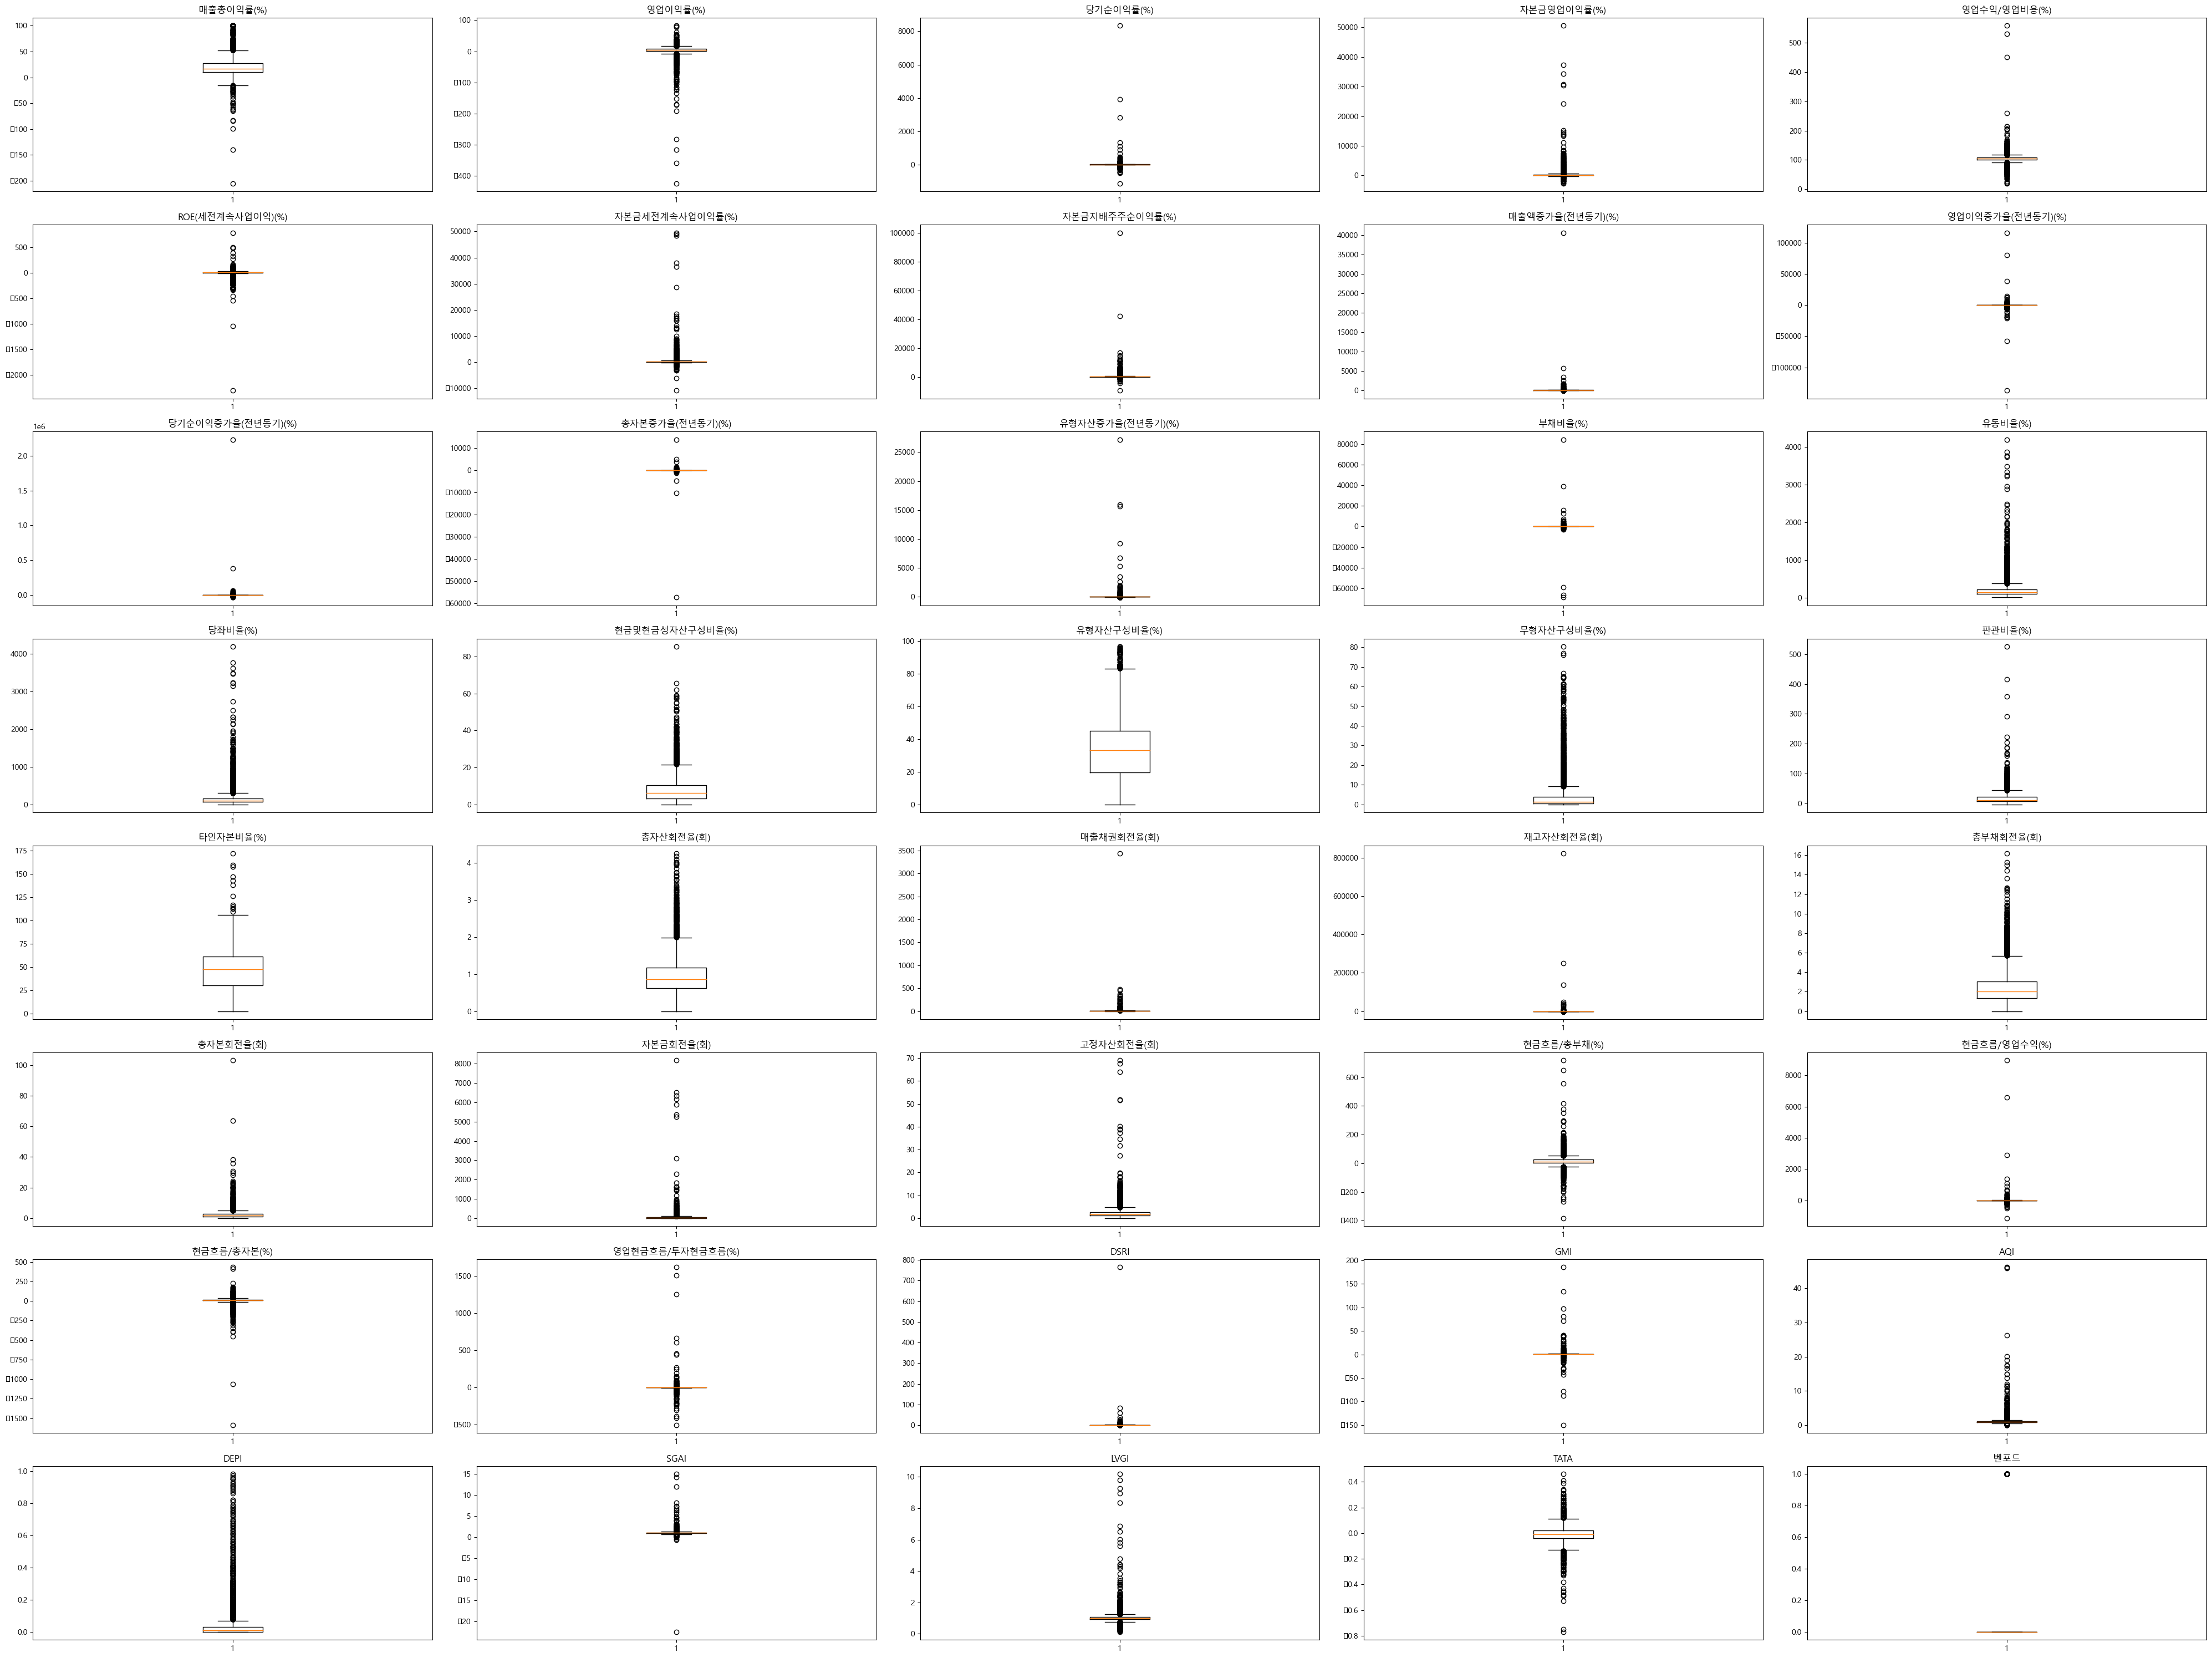

In [51]:
selected_variables = feature
# 5x4 subplot 생성
fig, axes = plt.subplots(8, 5, figsize=(40, 30))
axes = axes.flatten()  # 2D axes 배열을 1D 배열로 변환

for i, var in enumerate(selected_variables):
    # i번째 axes에 i번째 변수의 히스토그램을 그림
    axes[i].boxplot(df[var])
    axes[i].set_title(var)  # 각 히스토그램에 변수 이름을 제목으로 설정

plt.tight_layout()  # subplot 간격 조정
plt.show()

In [61]:
# 이상치 처리 데이터로 결합
df[df.columns[6:]] = feature
df.head()

,Symbol,Name,결산월,회계년,주기,분식기업,매출총이익률(%),영업이익률(%),당기순이익률(%),자본금영업이익률(%),...,현금흐름/총자본(%),영업현금흐름/투자현금흐름(%),DSRI,GMI,AQI,DEPI,SGAI,LVGI,TATA,벤포드
0,A095570,AJ네트웍스,12,2015,Annual,0.0,100.0,7.03,2.75,183.57,...,60.74,1.43,1.03,1.0,0.81,0.18,1.01,0.96,0.10,0
1,A095570,AJ네트웍스,12,2016,Annual,0.0,100.0,4.93,1.36,132.12,...,60.74,2.19,1.13,1.0,1.28,0.17,1.02,1.03,0.12,0
2,A095570,AJ네트웍스,12,2017,Annual,0.0,100.0,2.66,2.45,47.92,...,60.74,1.66,1.96,1.0,4.05,0.14,1.02,1.02,0.07,0
3,A095570,AJ네트웍스,12,2018,Annual,0.0,100.0,-2.03,3.56,-45.35,...,60.74,1.87,0.53,1.0,0.44,0.05,1.05,1.00,0.02,0
4,A095570,AJ네트웍스,12,2019,Annual,0.0,100.0,1.56,4.21,33.42,...,52.35,-0.85,1.36,1.0,1.80,0.07,0.96,1.00,0.03,0


In [63]:
# df.to_csv('../data/dataset/코스피_이상치처리완.csv', index = False, encoding = 'UTF-8-sig')

### IQR을 통해 전체 변수에 대해 상하위 1%씩 윈저라이징

이상치 상하위 1%씩 총 2% 윈저라이징

In [4]:
import numpy as np

def outliers_iqr(df, col):
    ## 1사분위수, 3사분위수 변수에 대입
    quartile_1, quartil3_3 = np.percentile(df[col], [1, 99])
    ## iqr 값을 대입
    iqr = quartil3_3 - quartile_1
    ## 하단 경계의 값, 상단 경계의 값
    lower_whis = quartile_1 - (1.5 * iqr)
    upper_whis = quartil3_3 + (1.5 * iqr)
    #print(f'하단 경계의 값 : {lower_whis}, 상단 경계의 값 : {upper_whis}')
    ## 데이터프레임에서 상단의 경계보다 크거나 하단의 경계보다 작은 데이터를 출력
    #outliers = df[(df[col] > upper_whis) | (df[col] < lower_whis)]
    df[col] = df[col].mask(df[col] < lower_whis, lower_whis)
    df[col] = df[col].mask(df[col] > upper_whis, upper_whis)
    return df
    #return outliers[[col]] # 시리즈가 아닌 데이터프레임 형태로 리턴

In [5]:
df.columns[6:-1]

Index(['매출총이익률(%)', '영업이익률(%)', '당기순이익률(%)', '자본금영업이익률(%)', '영업수익/영업비용(%)',
       'ROE(세전계속사업이익)(%)', '자본금세전계속사업이익률(%)', '자본금지배주주순이익률(%)',
       '매출액증가율(전년동기)(%)', '영업이익증가율(전년동기)(%)', '당기순이익증가율(전년동기)(%)',
       '총자본증가율(전년동기)(%)', '유형자산증가율(전년동기)(%)', '부채비율(%)', '유동비율(%)', '당좌비율(%)',
       '현금및현금성자산구성비율(%)', '유형자산구성비율(%)', '무형자산구성비율(%)', '판관비율(%)', '타인자본비율(%)',
       '총자산회전율(회)', '매출채권회전율(회)', '재고자산회전율(회)', '총부채회전율(회)', '총자본회전율(회)',
       '자본금회전율(회)', '고정자산회전율(회)', '현금흐름/총부채(%)', '현금흐름/영업수익(%)', '현금흐름/총자본(%)',
       '영업현금흐름/투자현금흐름(%)', 'DSRI', 'GMI', 'AQI', 'DEPI', 'SGAI', 'LVGI',
       'TATA'],
      dtype='object')

In [6]:
for col in df.columns[6:-1]:
    outliers_iqr(df, col)

In [7]:
df[df.columns[6:-1]].describe()

,매출총이익률(%),영업이익률(%),당기순이익률(%),자본금영업이익률(%),영업수익/영업비용(%),ROE(세전계속사업이익)(%),자본금세전계속사업이익률(%),자본금지배주주순이익률(%),매출액증가율(전년동기)(%),영업이익증가율(전년동기)(%),...,현금흐름/영업수익(%),현금흐름/총자본(%),영업현금흐름/투자현금흐름(%),DSRI,GMI,AQI,DEPI,SGAI,LVGI,TATA
count,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,...,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000,7029.000000
mean,22.214233,3.535648,1.650148,269.718994,104.869165,3.727847,271.599319,195.524001,9.273095,-13.988326,...,5.880056,9.138633,-1.316331,1.042338,1.005163,1.123905,0.037818,1.031271,1.011428,-0.010797
std,20.843268,12.014931,22.995030,757.050435,11.130006,30.115148,882.772068,694.654980,43.224553,521.087555,...,21.983251,25.718112,11.988252,0.553396,1.150366,0.727827,0.089672,0.273244,0.254851,0.063086
min,-169.576000,-144.225200,-252.965800,-2763.250000,19.020000,-358.737600,-7451.332600,-6084.796400,-99.860000,-5859.235400,...,-234.921800,-310.739000,-131.897000,0.000000,-9.932600,0.040000,0.000000,-1.660800,0.110000,-0.715000
25%,10.180000,1.390000,0.220000,15.110000,101.410000,1.080000,6.000000,2.420000,-4.470000,-46.510000,...,2.760000,5.060000,-1.790000,0.870000,0.900000,0.900000,0.000000,0.930000,0.930000,-0.040000
50%,16.360000,4.120000,2.960000,81.460000,104.300000,6.770000,73.680000,51.390000,3.760000,-3.650000,...,6.080000,10.450000,-0.850000,0.980000,1.000000,1.000000,0.010000,1.010000,0.990000,-0.010000
75%,27.210000,7.500000,6.390000,247.480000,108.110000,12.910000,256.230000,181.570000,13.890000,36.230000,...,10.280000,17.010000,-0.060000,1.100000,1.100000,1.130000,0.030000,1.090000,1.050000,0.020000
max,100.000000,82.100000,212.591000,9493.648400,241.332400,292.584000,11012.006600,8861.914000,519.168400,5392.180600,...,216.206200,283.448200,118.472600,7.365000,12.030600,9.648800,0.980000,4.128000,4.003800,0.460000


C:\Users\Master\AppData\Local\Temp\ipykernel_19964\730381593.py:17: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()  # subplot 간격 조정
c:\Users\Master\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


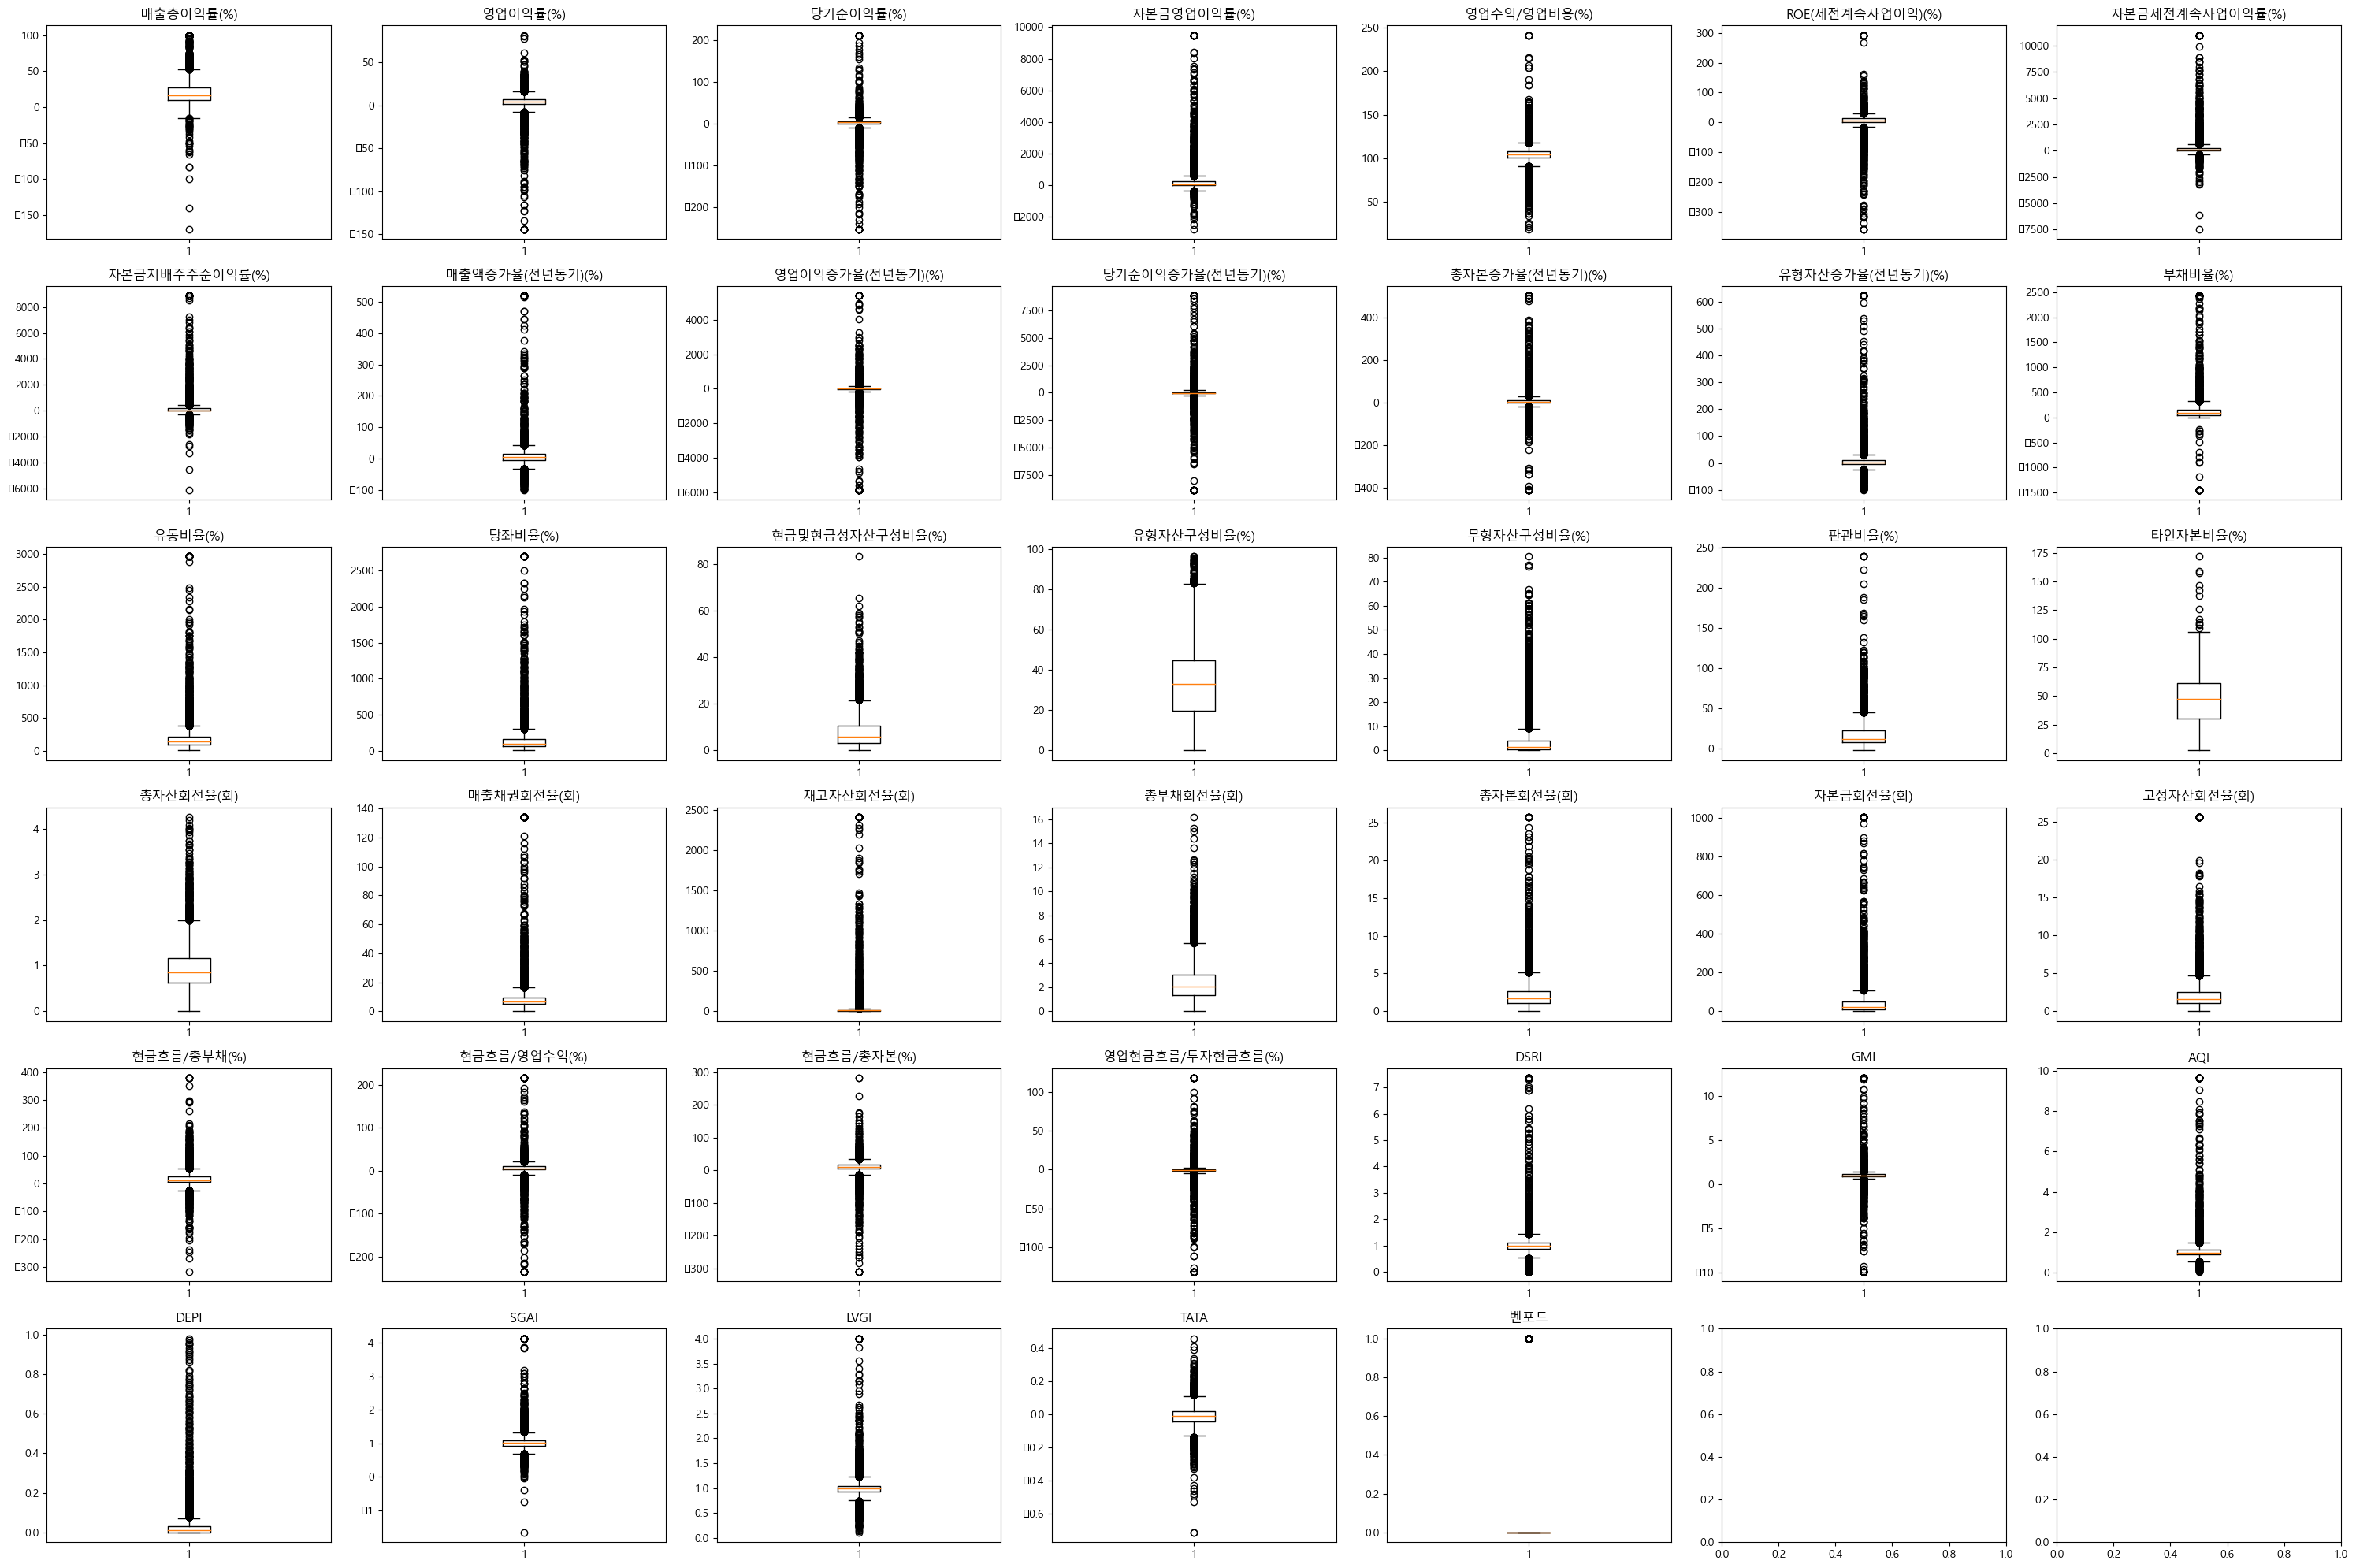

In [8]:
from matplotlib import font_manager, rc
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'

selected_variables = df[df.columns[6:]]
# 5x4 subplot 생성
fig, axes = plt.subplots(6, 7, figsize=(30, 20))
axes = axes.flatten()  # 2D axes 배열을 1D 배열로 변환

for i, var in enumerate(selected_variables):
    # i번째 axes에 i번째 변수의 히스토그램을 그림
    axes[i].boxplot(df[var])
    axes[i].set_title(var)  # 각 히스토그램에 변수 이름을 제목으로 설정

plt.tight_layout()  # subplot 간격 조정
plt.show()